# CBF-LLM / 2
* 新しい`llmcbf`を使用する．

# Imports

In [1]:
# PyTorch
import torch
from torch import tensor, Tensor, concat, argmax, argmin, sort, argsort, no_grad, hstack, concatenate, zeros, ones, \
    float32, arange, inference_mode, kron
from torch.nn.functional import softmax

# Transformers
import transformers
from transformers import TextStreamer

# Utilities
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from dataclasses import dataclass
from typing import List, Tuple
from abc import ABC, abstractmethod
from functools import cache
import japanize_matplotlib
from numpy import mean, std
import time

# Matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import Figure, Axes, subplot, subplots
from matplotlib.colors import LinearSegmentedColormap, TABLEAU_COLORS, to_rgb
from matplotlib import rcParams
rcParams["font.size"] = 16

# PyTorch Devices
cpu = torch.device("cpu")
cuda0 = torch.device("cuda:0")

# (Re)load My Modules
from importlib import reload
import llmcbf
import myautils

[reload(x) for x in [llmcbf, myautils]]
from llmcbf import *
from myautils import *

# Models

In [2]:
# 制約言語関数 cardiffnlp/twitter_roberta_base_sentiment_latest

from transformers import AutoModelForSequenceClassification, AutoTokenizer

name = "D:/TextClassificationModels/cardiffnlp_twitter-roberta-base-sentiment-latest"


def _mapper(output: SequenceClassifierOutput) -> List[float]:
    scores = torch.softmax(output[0], dim=1)
    negatives, neutrals, positives = scores.T
    h_list = positives - torch.max(negatives, neutrals)
    return tolist(h_list)


lcf = LanguageCF(
    AutoModelForSequenceClassification.from_pretrained(name).to(cuda0),
    AutoTokenizer.from_pretrained(name),
    _mapper,
    name="cardiffnlp/twitter_roberta_base_sentiment_latest"
)

Some weights of the model checkpoint at D:/TextClassificationModels/cardiffnlp_twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [72]:
# 制約言語関数 cardiffnlp/tweet-topic-21-multi
'''
"0": "arts_&_culture",
"1": "business_&_entrepreneurs",
"2": "celebrity_&_pop_culture",
"3": "diaries_&_daily_life",
"4": "family",
"5": "fashion_&_style",
"6": "film_tv_&_video",
"7": "fitness_&_health",
"8": "food_&_dining",
"9": "gaming",
"10": "learning_&_educational",
"11": "music",
"12": "news_&_social_concern",
"13": "other_hobbies",
"14": "relationships",
"15": "science_&_technology",
"16": "sports",
"17": "travel_&_adventure",
"18": "youth_&_student_life"
'''
from transformers import AutoModelForSequenceClassification, AutoTokenizer

name = "D:/TextClassificationModels/cardiffnlp_tweet-topic-21-multi"

constrained_topic_id = 8
mask = ones((19,), dtype=torch.bool)
mask[constrained_topic_id] = False
def _mapper(output: SequenceClassifierOutput) -> List[float]:
    scores = torch.softmax(output[0], dim=1)
    h_list = scores[:,constrained_topic_id] - torch.max(scores[:,mask])
    return tolist(h_list)


lcf = LanguageCF(
    AutoModelForSequenceClassification.from_pretrained(name).to(cuda0),
    AutoTokenizer.from_pretrained(name),
    _mapper,
    name="cardiffnlp/cardiffnlp_tweet-topic-21-multi"
)

In [3]:
# 制約言語関数 三好の文復元
from transformers import BertJapaneseTokenizer, BertModel
import torch
class SentenceBertJapanese:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)


sentencebert = SentenceBertJapanese("D:\\TextClassificationModels\\sentence-bert-base-ja-mean-tokens-v2")


AttributeError: 'SentenceBertJapanese' object has no attribute 'to'

In [4]:
TEST_SENTENCES = [
    "You have a good place",
    "You mst die !!!",
    "Today I'd like to make a sandwich!"
]
print("#Cache:", len(lcf.cache))
tic()
h_list = lcf.get_for_texts(TEST_SENTENCES)
toc()
print("#Cache:", len(lcf.cache))
print(h_list)

#Cache: 0
1.0441 秒
#Cache: 3
[0.7747807502746582, -0.8227026462554932, 0.47951483726501465]


In [3]:
# meta-ai/llama3-8b
from transformers import LlamaForCausalLM, LlamaTokenizer, AutoTokenizer

name = "D:\\TextGenerationModels\\meta-ai_llama3-8b"
Gm = LlamaForCausalLM.from_pretrained(name, torch_dtype=torch.float16).to(cuda0)
Gt = AutoTokenizer.from_pretrained(name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
streamer = TextStreamer(Gt)
vocab = Gt.get_vocab()
ivocab = {v: Gt.decode([v]).replace("\n", "") for k, v in vocab.items()}
VOCAB_SIZE = len(vocab)


@cache
def Gtokenize(xstr: str) -> Tensor:
    Ginputs = Gt(xstr, return_tensors="pt", add_special_tokens=False).to(cuda0)
    x = Ginputs.input_ids[0]
    return x

# Check

In [45]:
xstr = "Everyone says you will be a good researcher in the future, but"
x0 = Gtokenize(xstr)
# h0 = lcf.get_for_text(xstr)
print(f"{x0=}")
# print(f"{h0=}")

x0=tensor([34124,  2795,   499,   690,   387,   264,  1695, 32185,   304,   279,
         3938,    11,   719], device='cuda:0')


In [46]:
# 無制御下の決定論的な生成
x = x0.clone()
streamer.put(x)
for k in range(30):
    output = Gm(x[None])
    logit = output.logits[0][-1]
    iast = logit.argmax()
    if iast == Gt.eos_token_id:
        break
    x = hstack((x, iast))
    streamer.put(tensor(iast)[None])
streamer.end()

Everyone says you will be a good researcher in the future, but I think you 

C:\Users\omiya\AppData\Local\Temp\ipykernel_9880\406399342.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  streamer.put(tensor(iast)[None])


are already a good researcher. I am very proud of you. I am very proud of you. I am very proud of you.


In [9]:
# 確率論的な生成
TOPK = 50

# 制約なし
# scanner = JustTopkScanner(top_k=10)
# CBF制約
# scanner = CBFAllowanceScanner(top_k=TOPK, alpha=0.3, tokenizer=Gt, clf=clf)
# ブラックリスト制約
scanner = BlacklistFilter(top_k=TOPK, tokenizer=Gt, clf=lcf)

normalizer = MinJSDNormalizer()
TEMPERATURE = 1.0

In [10]:
x = x0.clone()
streamer.put(x)
for k in range(30):
    with no_grad():
        output = Gm(x[None])
    logit = output.logits[0][-1]
    P = distributionify(logit, temperature=TEMPERATURE)
    scan_result = scanner.scan(x, P)
    if scan_result.banned:
        print()
        print(f"{k=}")
        print(scan_result)
    Q = normalizer(P, scan_result.allowed)
    iast = Q.multinomial(num_samples=1)
    if iast == Gt.eos_token_id:
        break
    x = hstack((x, iast))
    streamer.put(iast)
streamer.end()

Everyone says you will be a good researcher in the future, 
k=0
FilterResult(allowed=[358, 499, 1148, 433, 1268, 430, 279, 1457, 369, 584, 656, 420, 304, 422, 1070, 1314, 701, 994, 520, 856, 4587, 690, 1176, 439, 889, 11, 311, 1193, 3604, 264, 682, 779, 3432, 1405, 7344, 602, 1603, 3156, 1095, 1243, 7170, 568, 2103, 5127, 1455, 1524, 198, 832, 1618, 1101], banned=[3249, 814, 912, 1541, 539, 649, 19093, 374, 527, 617, 1587], clf_mapping={358: 0.5644592046737671, 499: 0.34841758012771606, 1148: 0.13203656673431396, 433: 0.13708066940307617, 1268: 0.10968908667564392, 430: 0.40742236375808716, 279: 0.3438275158405304, 3249: -0.03480041027069092, 1457: 0.47203654050827026, 369: 0.45824286341667175, 584: 0.49261027574539185, 656: 0.11473935842514038, 814: -0.09734803438186646, 420: 0.4548119604587555, 912: -0.19824689626693726, 304: 0.2052314281463623, 422: 0.3580027222633362, 1070: 0.1004243791103363, 1314: 0.3973843455314636, 701: 0.2359503209590912, 1541: -0.04394906759262085, 994: 0.223

# Common

In [6]:
@inference_mode()
def generate(
        x0: Tensor,
        max_new_tokens: int,
        temperature: float,
        scanner: Filter,
        recalculator: Normalizer,
        stream: bool = True
):
    R = {"banned_tokens_history": [], "clf_mapping_history": []}
    x = x0.clone()

    for _ in range(max_new_tokens):
        output = Gm(x[None])
        logit = output.logits[0][-1]
        P = distributionify(logit, temperature=temperature)
        scan_result = scanner.scan(x, P)
        R["banned_tokens_history"].append(scan_result.banned)
        R["clf_mapping_history"].append(scan_result.clf_mapping)
        Q = recalculator.__call__(P, scan_result.allowed)
        iast = Q.multinomial(num_samples=1)
        if iast == Gt.eos_token_id:
            break
        x = hstack((x, iast))
        if stream:
            streamer.put(iast)

    if stream:
        streamer.end()

    R["xf"] = tolist(x)
    return R

In [7]:
def get_clf_history(x0: Tensor, xf: Tensor) -> List[float]:
    clf_history = []
    x0len = len(x0)
    xflen = len(xf)
    for i in range(x0len, xflen + 1):
        x = xf[:i]
        xstr = Gt.decode(x)
        hx = lcf.get_for_text(xstr)
        clf_history.append(hx)
    return clf_history

In [13]:
@no_grad
def get_perplexity(x0:Tensor, xf:Tensor, temperature:float)->float:
    x0len = len(x0)
    x = x0.clone()
    lp_sum = 0.0
    for k, iast in enumerate(xf[x0len:]):
        output = Gm(x[None])
        s = output.logits[0][-1]
        token_distribution = softmax(s/temperature, dim=0)
        i_prob = token_distribution[iast]
        lp_sum += i_prob.log()
        # print(k, Gt.decode(x), ivocab[toint(iast)], tofloat(i_prob))
        x = hstack((x, iast))
    lp_ave = lp_sum / (len(xf) - x0len)
    ppl = (-lp_ave).exp()
    return tofloat(ppl)

# E11/E15
トラックするもの
* 介入回数
* CLF軌道

## Sample

In [ ]:
x0str_list = [
    "Everyone says you will be a good researcher in the future, but",
    "In my opinion,",
    "That project was going well until last week,",
    "Finally,",
    "Though my idea was perfect,"
]
for x0str in x0str_list:
    x0 = Gtokenize(x0str)
    h0 = lcf.get_for_text(x0str)
    print(f"{x0str=} {h0=}")

x0str='Everyone says you will be a good researcher in the future, but' h0=0.28039610385894775
x0str='In my opinion,' h0=-0.6301379799842834
x0str='That project was going well until last week,' h0=-0.17377370595932007
x0str='Finally,' h0=0.6222823858261108


In [8]:
TOPK = 30
TEMPERATURE = 1
normalizer = MinJSDNormalizer()
MAX_NEW_TOKENS = 30

In [10]:
SAMPLE_SIZE = 10

In [11]:
FILTERS = {
    "NC": JustTopkFilter(TOPK, output_clf_mapping=True, tokenizer=Gt, clf=lcf),
    "CBF0.3": CBFFilter(TOPK, 0.3, Gt, lcf),
    "CBF0.8": CBFFilter(TOPK, 0.8, Gt, lcf),
    "BL": BlacklistFilter(TOPK, Gt, lcf),
}

In [26]:
lcf.get_for_text("Everyone is")

-0.3359489142894745

In [32]:
x0str = "No one"
print(x0str)
x0 = Gtokenize(x0str)

scanner = FILTERS["BL"]


for sample in tqdm(range(SAMPLE_SIZE)):
    R = generate(
        x0=x0, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE, scanner=scanner,
        recalculator=MinJSDNormalizer(), stream=False)
    xfstr = Gt.decode(R["xf"])
    # print(lcf.get_for_text(xfstr))
    print(json.dumps(xfstr, ensure_ascii=False)+",")

No one


C:\Users\omiya\AppData\Local\Temp\ipykernel_19308\3983022579.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/10 [00:00<?, ?it/s]

"No one happier than the 49ers at it not, it is a long time since they won a game, and it is only the second victory of ",
"No one disappoints me and I keep pushing him to play for us.”\nIn the past week, the president of the club revealed that Neymar and the PSG",
"No one greater ever existed than the Father Who sent us his Son. The Son is the same in substance as the Father, and he can never, by any",
"No one greater.\nGod is the Creator of everything and is the center of the creation. (Is the source of all that is).\nFor God all things are",
"No one happier than we were when, finally, the first\ncotton picked in that year was brought to us, and the first payment\nmade to the",
"No one:) Everyone will look out for themselves if the money is put into a common purse, so all will be satisfied, but if some do not look out",
"No one greater\nWhen I saw the movie, it gave me a good idea on who they could cast to play the part of Jesus, the man that came",
"No one happier to see the end of 

In [15]:
lcf.get_for_text(Gt.decode(R["xf"]))

0.5380286574363708

## Attractor

In [65]:
COLORS = {
    "CBF0.3": "tab:red",
    "CBF0.8": "tab:orange",
    "BL": "tab:blue",
    "NC": "black"
}
LABELS = {
    "CBF0.3": "CBF ($\\alpha =0.3$)",
    "CBF0.8": "CBF ($\\alpha =0.8$)",
    "BL": "Blacklist",
    "NC": "NoControl"
}
ALPHAS = {
    "CBF0.3": 0.3,
    "CBF0.8": 0.8,
    "BL": 1.0,
    "NC": None
}

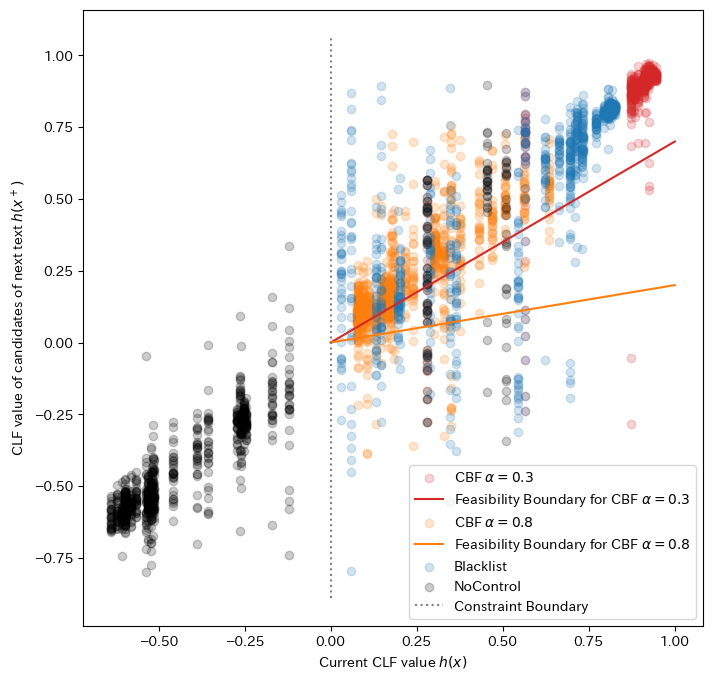

In [38]:
# 1
fig, ax = plt.subplots(figsize=(8, 8))


def _1(R, color, label, alpha=None):
    clf_hisory = R["clf_history"]
    xdata = []
    ydata = []
    for hk, clf_mapping in zip(clf_hisory, R["clf_mapping_history"]):
        for hnext in clf_mapping.values():
            xdata.append(hk)
            ydata.append(hnext)
    ax.scatter(xdata, ydata, c=color, label=label, alpha=0.2)
    if alpha:
        slope = 1 - alpha
        xmax = 1
        ax.plot([0, xmax], [0, xmax * slope], color=color, label=f"Feasibility Boundary for {label}")


_1(cbf03_generate_result, "tab:red", "CBF $\\alpha=0.3$", alpha=0.3)
_1(cbf08_generate_result, "tab:orange", "CBF $\\alpha=0.8$", alpha=0.8)
_1(bl_generate_result, "tab:blue", "Blacklist")
_1(nc_generate_result, "black", "NoControl")

ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors="gray", ls=":", label="Constraint Boundary")

ax.legend()
ax.set_xlabel("Current CLF value $h(x)$")
ax.set_ylabel("CLF value of candidates of next text $h(x^+)$")
plt.show()

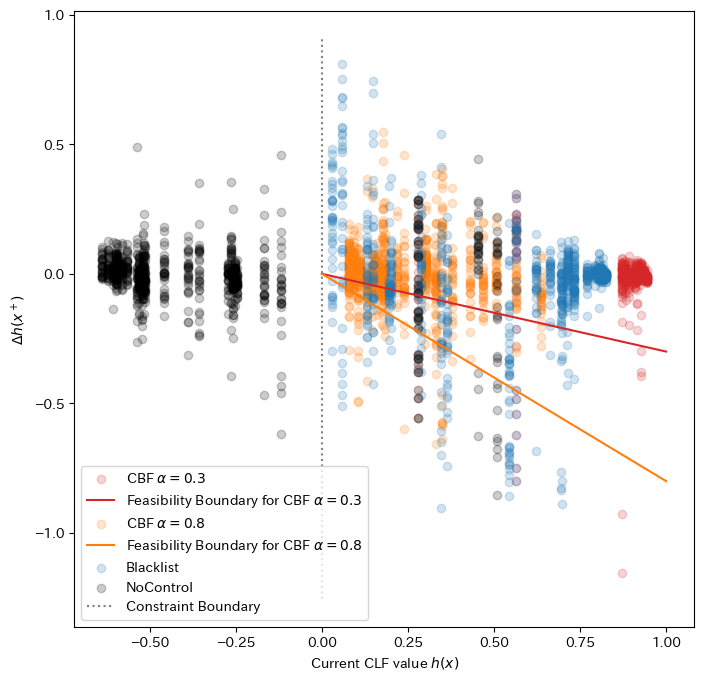

In [45]:
# 1
fig, ax = plt.subplots(figsize=(8, 8))


def _1(R, color, label, alpha=None):
    clf_hisory = R["clf_history"]
    xdata = []
    ydata = []
    for hk, clf_mapping in zip(clf_hisory, R["clf_mapping_history"]):
        for hnext in clf_mapping.values():
            xdata.append(hk)
            ydata.append(hnext - hk)
    ax.scatter(xdata, ydata, c=color, label=label, alpha=0.2)
    if alpha:
        slope = -alpha
        xmax = 1
        ax.plot([0, xmax], [0, xmax * slope], color=color, label=f"Feasibility Boundary for {label}")


_1(cbf03_generate_result, "tab:red", "CBF $\\alpha=0.3$", alpha=0.3)
_1(cbf08_generate_result, "tab:orange", "CBF $\\alpha=0.8$", alpha=0.8)
_1(bl_generate_result, "tab:blue", "Blacklist")
_1(nc_generate_result, "black", "NoControl")

ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors="gray", ls=":", label="Constraint Boundary")

ax.legend()
ax.set_xlabel("Current CLF value $h(x)$")
ax.set_ylabel("$\\Delta h(x^+)$")
plt.show()

In [46]:
save(fig, "E11/2.CLFAttracters.B.pdf")

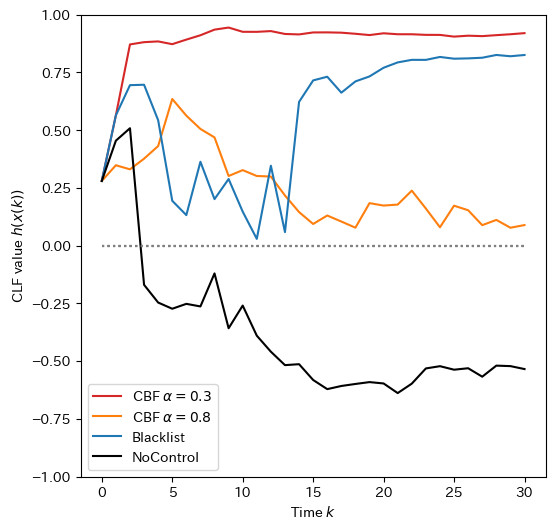

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


def _1(generation_result, color, label):
    clf_history = get_clf_history(x0, generation_result["xf"])
    ax.plot(clf_history, color=color, label=label)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Time $k$")
    ax.set_ylabel("CLF value $h(x(k))$")
    ax.hlines(0, 0, MAX_NEW_TOKENS, color="gray", ls=":")
    ax.legend()


_1(cbf03_generate_result, "tab:red", "CBF $\\alpha=0.3$")
_1(cbf08_generate_result, "tab:orange", "CBF $\\alpha=0.8$")
_1(bl_generate_result, "tab:blue", "Blacklist")
_1(nc_generate_result, "black", "NoControl")
plt.show()

In [41]:
save(fig, "E11/2.CLFValueHistory.pdf")

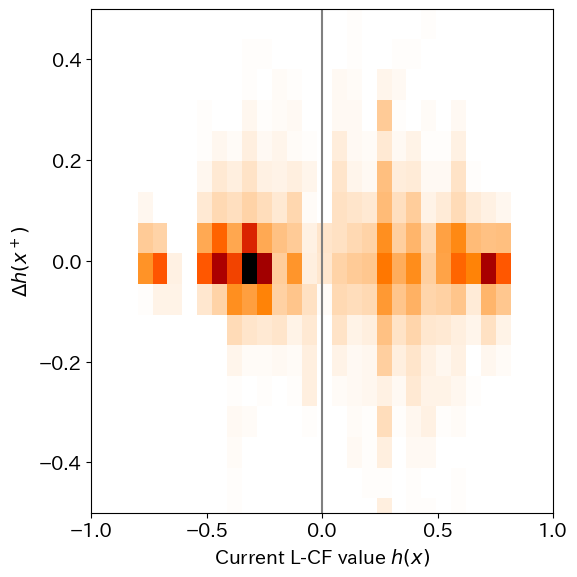

In [78]:
rcParams["font.size"] = 14

keys = ["CBF0.3", "CBF0.8", "BL", "NC"]
keys = [keys[3]]
fig, axs = plt.subplots(1, len(keys), figsize=(6, 6))
if len(keys) == 1:
    axs = [axs]

for i, key in enumerate(keys):
    ax = axs[i]
    records = result_data[key]
    xdata = []
    ydata = []
    for idx in range(SAMPLE_SIZE):
        R = records[idx]
        color = COLORS[key]
        label = LABELS[key]
        alpha = ALPHAS[key]
        clf_history = get_clf_history(x0, R["xf"])

        for hk, clf_mapping in zip(clf_history, R["clf_mapping_history"]):
            xdata += [hk] * len(clf_mapping)
            for hnext in clf_mapping.values():
                ydata.append(hnext - hk)
    hist = ax.hist2d(xdata, ydata, cmap="gist_heat_r", bins=(25, 35))

    if alpha:
        slope = -alpha
        xmax = 1
        ax.plot([0, xmax], [0, xmax * slope], color="k", ls=":", label=f"Constraint")

    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors="gray", ls="-")
    # ax.legend(loc="upper right")
    ax.set_xlabel("Current L-CF value $h(x)$")
    if i == 0:
        ax.set_ylabel("$\\Delta h(x^+)$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, 0.5)
fig.tight_layout()
plt.show()

In [79]:
save(fig, f"E11/3.Attracters.{keys[0]}.pdf")

## Banned Tokens

In [128]:
mean_n_banned_tokens_dic = {}
std_n_banned_tokens_dic = {}
for label, samples in result_data.items():
    print(label)
    n_banned_tokens_list = []
    for sample in samples:
        n_banned_tokens = sum(len(x) for x in sample["banned_tokens_history"])
        n_banned_tokens_list.append(n_banned_tokens)
    mean_n_banned_tokens_dic[label] = numpy.mean(n_banned_tokens_list)
    std_n_banned_tokens_dic[label] = numpy.std(n_banned_tokens_list)


NC
CBF0.3
CBF0.8
BL


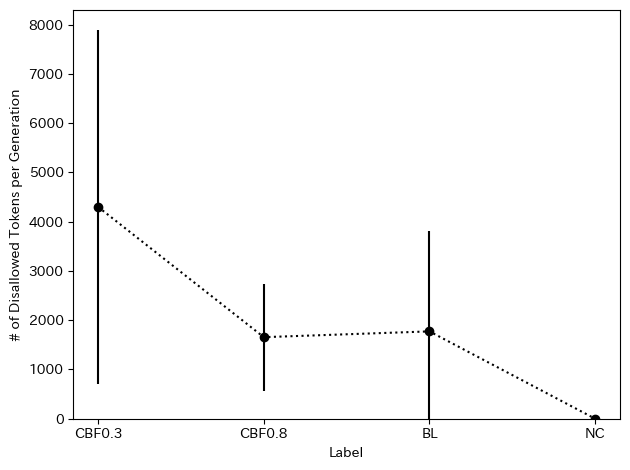

In [133]:
fig_label_vs_banning, ax = subplots(facecolor="white")
LABELS = ["CBF0.3", "CBF0.8", "BL", "NC"]
ax.errorbar(
    range(len(LABELS)),
    [mean_n_banned_tokens_dic[label] for label in LABELS], 
    [std_n_banned_tokens_dic[label] for label in LABELS],
    color="k", ls=":", marker="o")
# ax.plot([mean_n_banned_tokens_dic[label] for label in LABELS], "k:o")
ax.set_xlabel("Label")
ax.set_ylabel("# of Disallowed Tokens per Generation")
fig_label_vs_banning.tight_layout()
ax.set_ylim(bottom=0)
ax.set_xticks(range(len(LABELS)), LABELS)
plt.show()

In [134]:
save(fig_label_vs_banning, "E14/3.LabelVsBanning.pdf")

In [121]:
for key, records in result_data.items():
    print(key)
    n_banned_times = 0
    n_banned_tokens = 0
    for record in records:
        banned_tokens_history = record["banned_tokens_history"]
        for banned_tokens in banned_tokens_history:
            if len(banned_tokens) > 0:
                n_banned_times += 1
            n_banned_tokens += len(banned_tokens)
    print(f"{n_banned_times=} {n_banned_tokens=}")

NC
n_banned_times=0 n_banned_tokens=0
CBF0.3
n_banned_times=41 n_banned_tokens=42977
CBF0.8
n_banned_times=55 n_banned_tokens=16550
BL
n_banned_times=69 n_banned_tokens=17724


## Text List

In [76]:
for key, records in result_data.items():
    for i, record in enumerate(records):
        print(key, i)
        print(Gt.decode(record["xf"]).replace("\n", "\\LineBreak "))

CBF0.3 0
Everyone says you will be a good researcher in the future, but you are already an excellent researcher now. You’ve achieved excellent achievements. I’m so proud to be your professor.”\LineBreak The paper was published on Nature Medicine
CBF0.3 1
Everyone says you will be a good researcher in the future, but you won... more\LineBreak How long do I have to keep the sample for my experiment to make sure the experiment does give the true... more
CBF0.3 2
Everyone says you will be a good researcher in the future, but you're really a very good researcher. (Interviewees X, M, and C)\LineBreak I do feel as though I've contributed, I don't
CBF0.3 3
Everyone says you will be a good researcher in the future, but you should have a solid background on physics before then!"\LineBreak But, I want to become a researcher (mathematician) in the not-so-distant
CBF0.3 4
Everyone says you will be a good researcher in the future, but I have already decided that I will be a good researcher right now

## L-CF Trajectory Plots

In [13]:
# E11/3
IDXS = {
    "CBF0.3": 14,
    "CBF0.8": 11,
    "BL": 2,
    "NC": 12
}
for key, idx in IDXS.items():
    print(key)
    record = result_data[key][idx]
    print(Gt.decode(record["xf"]))

CBF0.3
Everyone says you will be a good researcher in the future, but you are already such a good one now.
It was my pleasure to get to know you when I came to the University for my fieldwork. I
CBF0.8
Everyone says you will be a good researcher in the future, but I want to encourage you to be a good researcher now,” he said. “I remember reading somewhere that ‘good research is always useful.’ You can
BL
Everyone says you will be a good researcher in the future, but I donot belie...

You can write a book, so can everyone.

There is always plenty to learn, I want my life...

I am happy
NC
Everyone says you will be a good researcher in the future, but you are not so much. Why?

What advice could you give to others who are studying the same subjects as you?

What has been your biggest failure


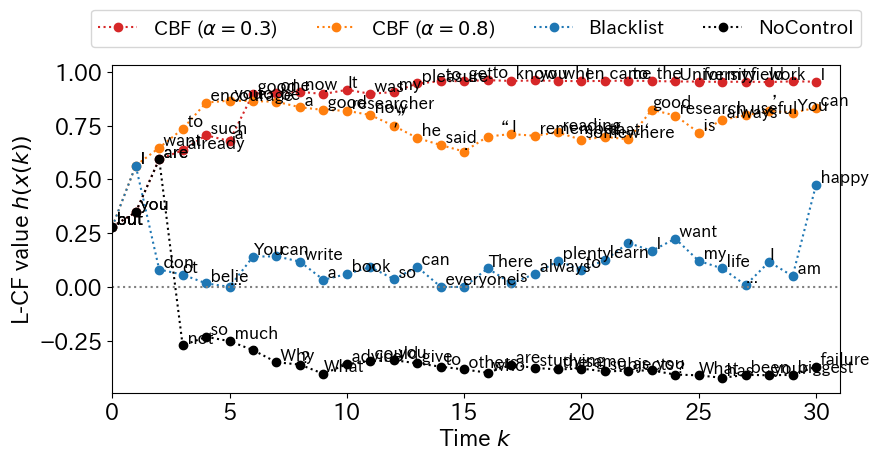

In [52]:
keys = ["CBF0.3", "CBF0.8", "BL", "NC"]
fig, ax = plt.subplots(figsize=(9, 5))
for key in keys:
    record = result_data[key][IDXS[key]]
    xf = record["xf"]
    clm_history = get_clf_history(x0, xf)
    xg = xf[len(x0) - 1:]
    ax.plot(clm_history, marker="o", ls=":", label=LABELS[key], color=COLORS[key])
    for k, tk in enumerate(tonumpy(xg)):
        tstr = ivocab[tk]
        ax.text(k, clm_history[k] + 0.01, tstr, fontsize=12)

ax.set_xlim(0, MAX_NEW_TOKENS + 1)
ax.hlines(0, *ax.get_xlim(), color="gray", ls=":")
ax.set_xlabel("Time $k$")
ax.set_ylabel("L-CF value $h(x(k))$")
ax.legend(loc="upper center", bbox_to_anchor=(0.5,+1.2), fontsize=14, ncol=4)
fig.tight_layout()
plt.show()

In [53]:
save(fig, "E11/3.CLFTrajectory.1.pdf")

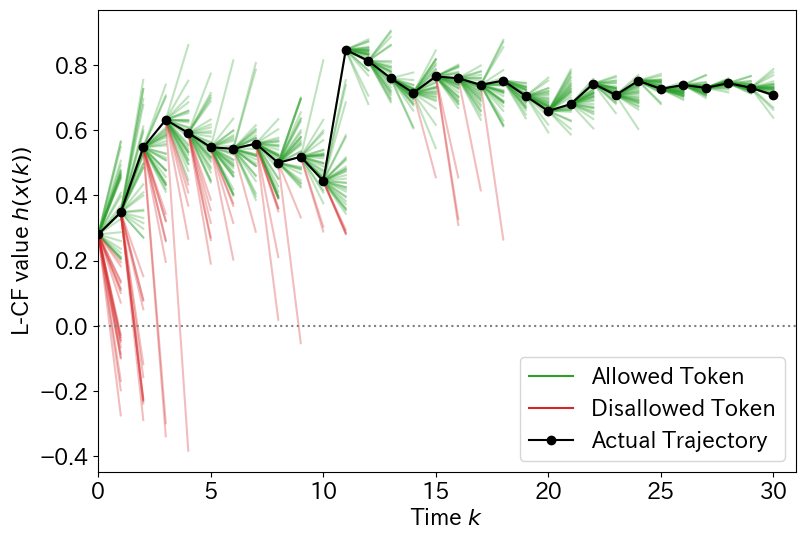

In [54]:
fig, ax = plt.subplots(figsize=(9, 6))

key = "CBF0.3"
record = result_data[key][34]

xf = record["xf"]
clf_history = get_clf_history(x0, xf)
xg = xf[len(x0) - 1:]

for k, tk in enumerate(tonumpy(xg)):
    h = clf_history[k]
    if k==len(xg)-1:
        continue
    for t_cd, h_cd in record["clf_mapping_history"][k].items():
        if t_cd in record["banned_tokens_history"][k]:
            color = "tab:red"
        else:
            color= "tab:green"
        ax.plot([k, k + 1], [h, h_cd], color=color, alpha=0.3)
        
# for k, tk in enumerate(tonumpy(xg)):
#     tstr = ivocab[tk]
#     h = clf_history[k]
#     ax.text(k, h + 0.01, tstr, c="k")

# 凡例のためだけの架空のグラフ
ax.plot([], [],ls="-", label="Allowed Token", color="tab:green")
ax.plot([],[],ls="-", label="Disallowed Token", color="tab:red")


ax.plot(clf_history, marker="o", label="Actual Trajectory", color="k")
plt.legend()
ax.set_xlabel("Time $k$")
ax.set_ylabel("L-CF value $h(x(k))$")
ax.set_xlim(0, MAX_NEW_TOKENS + 1)
ax.hlines(0, *ax.get_xlim(), color="gray", ls=":")
plt.show()

In [55]:
save(fig, "E11/3.CLFPredTrajectory.CBF0.3.34.pdf")

# E14

In [123]:
# x0str = "Everyone says you will be a good researcher in the future, but"
x0str = "Until yesterday my health was very good, but"
x0 = Gtokenize(x0str)
h0 = lcf.get_for_text(x0str)
print(f"{x0=}")
print(f"{h0=}")

TOPK = 30
TEMPERATURE = 1
normalizer = MinJSDNormalizer()
MAX_NEW_TOKENS = 30

x0=tensor([25503, 13985,   856,  2890,   574,  1633,  1695,    11,   719],
       device='cuda:0')
h0=0.7302209138870239


## NoControl

In [125]:

generate(
    x0=x0, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE, scanner=JustTopkFilter(TOPK),
    recalculator=MinJSDNormalizer(), stream=True
)

 I had to make sure that this situation would not affect other people. I want them to stay healthy and to follow the guidelines and protocols set by the


{'banned_tokens_history': [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 'clf_mapping_history': [{},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {},
  {}],
 'xf': tensor([25503, 13985,   856,  2890,   574,  1633,  1695,    11,   719,   358,
          1047,   311,  1304,  2771,   430,   420,  6671,  1053,   539,  7958,
          1023,  1274,    13,   358,  1390,  1124,   311,  4822,  9498,   323,
           311,  1833,   279, 17959,   323, 32885,   743,   555,   279],
        device='cuda:0')}

## CBF Control

In [4]:
ALPHAS = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]

In [5]:
SAMPLE_SIZE = 100

In [121]:
# 無制御でのサンプル生成
e14nc_xfs = []
for i in tqdm(range(SAMPLE_SIZE)):
    result = generate(x0, MAX_NEW_TOKENS, TEMPERATURE, JustTopkFilter(TOPK), MinJSDNormalizer(), stream=False)
    e14nc_xfs.append(tolist(result["xf"]))

C:\Users\omiya\AppData\Local\Temp\ipykernel_4156\1176253535.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [122]:
for xf in e14nc_xfs:
    print(Gt.decode(xf))

From yesterday my health was very good, but now I'm feeling really weak and my heart started racing for about 40 minutes straight. The first time I've ever had this happen. It's
From yesterday my health was very good, but now I feel uncomfortable with my stomach a little heavy from eating some vegetables, so please let me know if I do not eat vegetables
Can you eat
From yesterday my health was very good, but today due to the bad weather I had to eat more than normal. But now I've gained weight again. And there's nothing I can do,
From yesterday my health was very good, but now it's very bad. Please, I ask you to pray that I recover soon.
I'm asking you also to pray for the safety of my
From yesterday my health was very good, but now, today, I’ve got a lot of pain, the chest ache, the fever... They told me to do the test in 14 days
From yesterday my health was very good, but today my body is very weak and my health is bad,” she tells us.
I ask her what the difference is and she replies:

In [64]:
# 【時間がかかる】サンプル生成
def e14_sample(alpha: float):
    result = generate(
        x0, MAX_NEW_TOKENS, TEMPERATURE,
        CBFFilter(TOPK, alpha, Gt, lcf), MinJSDNormalizer(), stream=False)
    sample = {
        "banned_tokens_history": result["banned_tokens_history"],
        "xf": tolist(result["xf"]),
    }
    return sample


e14result = {}
for alpha in ALPHAS:
    print(f"{alpha=}")
    e14result[alpha] = []
    for i in tqdm(range(SAMPLE_SIZE)):
        sample = e14_sample(alpha)
        e14result[alpha].append(sample)


alpha=0.0


C:\Users\omiya\AppData\Local\Temp\ipykernel_4156\336457775.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(SAMPLE_SIZE)):


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.2


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.4


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.6


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.7


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.8


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.9


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であり，そちらを使う方がパフォーマンスが高いです．
alpha=1は`BlacklistAllowanceScanner`と等価であ

In [120]:
# 生成テキスト出力
for alpha in ALPHAS:
    print(f"{alpha=}")
    samples = e14result[alpha]
    for sample in samples:
        xfstr = Gt.decode(sample["xf"])
        print(xfstr)

alpha=0.0
From yesterday my health was very good, but since yesterday morning at noon onwards since from that.
* Yes
_7):Praise, congratulations, blessings_: (D x x xxoxoo
From yesterday my health was very good, but in one step up big one more to go, big smile, big laughter, today too cool, big cool… big love everybody, very very love
From yesterday my health was very good, but since yesterday evening after work he also improved, so he was very good today too, especially today, more good, today, very happy! Today,
From yesterday my health was very good, but on closer study since it started yesterday morning (11:11~) more health comes more more health all the way great!
Since I started working closer
From yesterday my health was very good, but we are going home, so thank you very much for everything, we’re happy!
It´s always pleasant here! :D
Hi everybody! �
From yesterday my health was very good, but on both fronts, physically and mentally.
I made love with my mother yesterday. God, it

In [77]:
# CLF軌跡を求める
for alpha in ALPHAS:
    print(f"{alpha=}")
    samples = e14result[alpha]
    for sample in samples:
        clf_history = get_clf_history(x0, sample["xf"])
        sample["clf_history"] = clf_history

alpha=0.0
alpha=0.1
alpha=0.2
alpha=0.3
alpha=0.4
alpha=0.5
alpha=0.6
alpha=0.7
alpha=0.8
alpha=0.9
alpha=1.0


In [94]:
save(e14result, "E14/5.CBFs.pkl")

In [2]:
e14result = load("E14/5.CBFs.pkl")

In [6]:
# CLF平均値
meanclf_list = []
for alpha in ALPHAS:
    samples = e14result[alpha]
    clf_list = []
    for sample in samples:
        clf_list += sample["clf_history"]
    meanclf = numpy.mean(clf_list)
    meanclf_list.append(meanclf)

In [8]:
# トークン排除のあった時刻の個数カウント
mean_banning_time_list = []
std_banning_time_list = []
for alpha, e14result_alpha in e14result.items():
    print(alpha)
    banning_time_list = []
    for sample in e14result_alpha:
        banning_time = sum(1 for x in sample["banned_tokens_history"] if len(x)>0)
        banning_time_list.append(banning_time)
    mean_banning_time_list.append(numpy.mean(banning_time_list))
    std_banning_time_list.append(numpy.std(banning_time_list))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


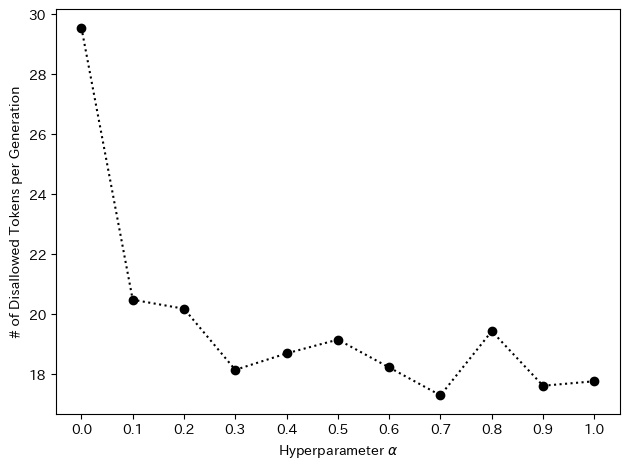

In [9]:
fig_A, ax = subplots(facecolor="white")
start = 0
# ax.errorbar(ALPHAS[start:], mean_n_banned_tokens_list[start:], std_n_banned_tokens_list[start:], color="k", ls=":", marker="o")
ax.plot(ALPHAS[start:], mean_banning_time_list[start:], "k:o")
ax.set_xlabel("Hyperparameter $\\alpha$")
ax.set_ylabel("# of Disallowed Tokens per Generation")
fig_A.tight_layout()
# ax.set_ylim(bottom=0)
ax.set_xticks(ALPHAS[start:], ALPHAS[start:])
plt.show()

In [10]:
# 排除トークン数のカウント
mean_n_banned_tokens_list = []
std_n_banned_tokens_list = []
for alpha, e14result_alpha in e14result.items():
    print(alpha)
    n_banned_tokens_list = []
    for sample in e14result_alpha:
        n_banned_tokens = sum(len(x) for x in sample["banned_tokens_history"])
        n_banned_tokens_list.append(n_banned_tokens)
    mean_n_banned_tokens_list.append(numpy.mean(n_banned_tokens_list))
    std_n_banned_tokens_list.append(numpy.std(n_banned_tokens_list))


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [11]:
XTICLABELS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, "BL"]

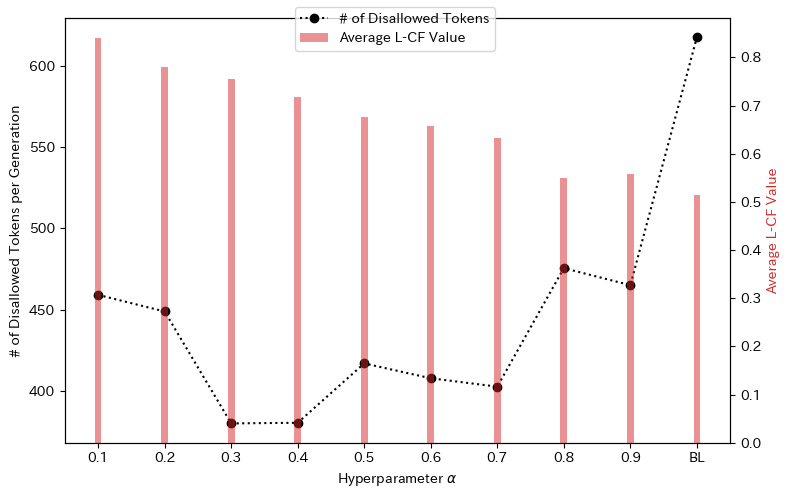

In [19]:
# α vs 排除トークン数と言語制約関数の平均値
fig_A, ax = subplots(facecolor="white", figsize=(8,5))
start = 1
# ax.errorbar(ALPHAS[start:], mean_n_banned_tokens_list[start:], std_n_banned_tokens_list[start:], color="k", ls=":", marker="o")
rax = ax.twinx()

ax.plot(ALPHAS[start:], mean_n_banned_tokens_list[start:], "k:o", label="# of Disallowed Tokens")
rax.bar(ALPHAS[start:], meanclf_list[start:], width=0.01, color="tab:red", alpha=0.5, label="Average L-CF Value")

rax.set_ylabel("Average L-CF Value", color="tab:red")
ax.set_ylabel("# of Disallowed Tokens per Generation")
ax.set_xlabel("Hyperparameter $\\alpha$")
ax.set_xticks(ALPHAS[start:], ALPHAS[start:])
ax.set_xticklabels(XTICLABELS[start:])
# ax.set_ylim(bottom=0)

fig_A.tight_layout()
fig_A.legend(loc="upper center")
plt.show()

In [14]:
fig_A.savefig("E14/5.A.png")

In [20]:
save(fig_A, "E14/5.A.pdf")

In [82]:
meanclf_list

[0.9543655351981379,
 0.8397113519268862,
 0.7798678424031265,
 0.7544436988154606,
 0.7181831136253671,
 0.6764924928642089,
 0.6583171705012189,
 0.6333160522766839,
 0.550356088991393,
 0.5576856612486224,
 0.5140593035759464]

In [80]:
save(fig_A, "E14/5.AlphaVsDisallowTokens.0.pdf")

In [25]:
mean_ppl_list = []
std_ppl_list = []
for alpha, e14result_alpha in e14result.items():
    print(f"{alpha=}")
    ppl_list = []
    for sample in tqdm(e14result_alpha):
        ppl = get_perplexity(x0, tensor(sample["xf"], device=x0.device), TEMPERATURE)
        ppl_list.append(ppl)
    mean_ppl_list.append(numpy.mean(ppl_list))
    std_ppl_list.append(numpy.std(ppl_list))

alpha=0.0


C:\Users\omiya\AppData\Local\Temp\ipykernel_6128\1861477249.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(e14result_alpha):


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.2


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.4


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.6


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.7


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.8


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=0.9


  0%|          | 0/100 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100 [00:00<?, ?it/s]

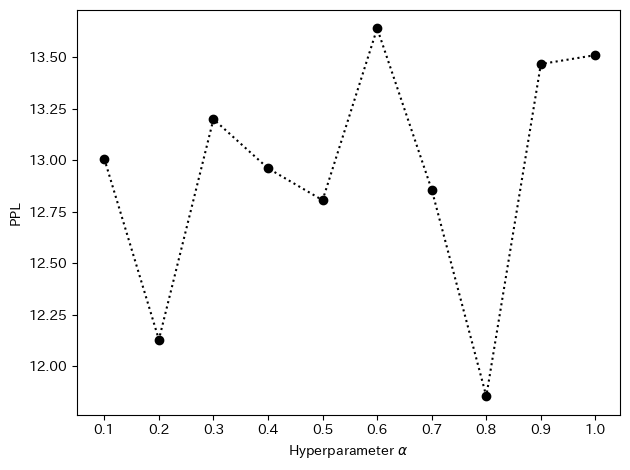

In [45]:
fig_alpha_vs_ppl, ax = subplots(facecolor="white")
start = 1
# ax.errorbar(ALPHAS[start:], mean_ppl_list[start:], std_ppl_list[start:],color="k", ls=":", marker="o")
ax.plot(ALPHAS[start:], mean_ppl_list[start:], "k:o")
ax.set_xlabel("Hyperparameter $\\alpha$")
ax.set_ylabel("PPL")
fig_alpha_vs_ppl.tight_layout()
# ax.set_ylim(bottom=0)
ax.set_xlim(left=0.05)
ax.set_xticks(ALPHAS[start:], ALPHAS[start:])
plt.show()

In [46]:
save(fig_alpha_vs_ppl, "E14/2.AlphaVsPPL.2.pdf")

In [27]:
cbf08_generate_result["banned_tokens_history"]

[[3249, 814, 912, 1541, 539, 649, 19093, 374, 527, 617],
 [656,
  649,
  690,
  1053,
  1587,
  1436,
  2586,
  1288,
  12671,
  617,
  7673,
  3629,
  2653,
  706],
 [12917, 3815, 433, 6261, 3495, 3318, 994, 311],
 [3300,
  433,
  499,
  6261,
  19564,
  2555,
  832,
  5208,
  3495,
  4885,
  20492,
  19035,
  1274,
  2574,
  9698,
  1124,
  11429,
  709,
  1884,
  14247,
  4442,
  9045],
 [5496, 2349, 7076, 5597, 5818, 3495, 20212, 2626, 5684, 4632, 2027],
 [32185,
  3495,
  2027,
  5597,
  10896,
  17850,
  28568,
  2626,
  3674,
  2883,
  323,
  15779,
  3241,
  14584,
  1934],
 [],
 [],
 [3347],
 [],
 [2650, 3639, 2100, 8595, 3277],
 [15],
 [1486, 4],
 [],
 [],
 [],
 [],
 [1541],
 [19781, 13326, 2362, 33630, 22568, 43206, 39019],
 [],
 [],
 [1063],
 [21958],
 [25382, 21958],
 [4619, 4856, 1093],
 [6033, 295],
 [1541, 912, 4250, 3009],
 [2753, 1148],
 [20985, 41564, 1716, 49080],
 [539, 477]]

In [25]:
tolist(cbf08_generate_result["xf"])

[34124,
 2795,
 499,
 690,
 387,
 264,
 1695,
 32185,
 304,
 279,
 3938,
 11,
 719,
 1268,
 922,
 3339,
 264,
 1695,
 1212,
 304,
 279,
 3118,
 30,
 220,
 16,
 14,
 23,
 198,
 4599,
 499,
 3719,
 264,
 7491,
 315,
 701,
 1866,
 2324,
 7509,
 283,
 3719,
 264,
 7491,
 315]

# E-15 三好の文復元

SentenceTransformerは`LanguageCF`に対応していない！！

In [12]:
from torch.linalg import norm

In [131]:
TARGET_SENTENCES = [
    "女の子が歌を歌っています",
    "バナナを持った人が道路を通行しています",
    "男性がスケートボードをしています"
]
target_sentence = TARGET_SENTENCES[0]

In [10]:
target_embedding = sentencebert.encode([target_sentence])[0]

In [16]:
Gt.decode(Gt.encode("はろはろー"))

'<|begin_of_text|>はろはろー'

In [17]:
Gt.decode(Gt.encode(""))

'<|begin_of_text|>'

In [18]:
Gt.encode("")

[128000]

In [21]:
Gm(tensor([[128000]]).to(cuda0))

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 6.8789,  8.7969, 12.9609,  ..., -4.4453, -4.4453, -4.4453]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[ 5.0781e-01,  9.3506e-01,  9.2188e-01,  ...,  1.2695e+00,
           -2.0691e-01,  2.4011e-01]],

         [[ 1.4610e-02, -2.3071e-02,  1.3397e-02,  ..., -6.8213e-01,
            3.7476e-01, -2.1558e-01]],

         [[ 2.5116e-02,  4.6814e-02, -5.8105e-02,  ...,  2.0386e-01,
            1.5303e+00, -5.8740e-01]],

         ...,

         [[-1.2512e-01, -3.2074e-02, -3.1471e-04,  ...,  1.4053e+00,
           -6.4160e-01,  4.3896e-01]],

         [[-3.8391e-02, -9.2285e-02,  6.0303e-02,  ...,  2.1692e-01,
           -1.2445e-01,  3.7231e-02]],

         [[-4.3610e-02, -1.8542e-01, -3.8879e-02,  ...,  2.0859e+00,
            1.4258e+00,  1.2744e+00]]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddBackward0>), tensor([[[[ 1.5381e-02,  8.0442e-04,  3.3386e-02,  

In [35]:
concatenate((x0,tensor(29).to(cuda0)[None]))

tensor([128000,     29], device='cuda:0')

In [153]:
TARGET_SENTENCE = TARGET_SENTENCES[2]
print(TARGET_SENTENCE)
TARGET_EMBEDDING = sentencebert.encode([TARGET_SENTENCE])[0]


def scan_by_embedding_distance(x: Tensor, P: Tensor, top_k: int) -> FilterResult:
    R = FilterResult()
    xstr = Gt.decode(x, skip_special_tokens=True)
    xemb = sentencebert.encode([xstr])[0]
    current_distance = norm(TARGET_EMBEDDING - xemb)

    sorted_next_tokens = P.argsort(descending=True)
    search_idx = 0
    searched_cnt = 0
    allowed_cnt = 0
    while allowed_cnt < top_k:
        next_token = sorted_next_tokens[search_idx]
        next_x = hstack((x, next_token))
        next_xstr = Gt.decode(next_x, skip_special_tokens=True)
        next_xemb = sentencebert.encode([next_xstr])[0]
        next_distance = norm(TARGET_EMBEDDING - next_xemb)
        if current_distance*1.0 >= next_distance:
            R.allowed.append(next_token.item())
            allowed_cnt += 1
        else:
            R.banned.append(next_token.item())
        searched_cnt += 1
        search_idx += 1
    return R

男性がスケートボードをしています


In [154]:
x0 = tensor(Gt.encode("男性が", add_special_tokens=True)).to(cuda0)

In [155]:
x = x0.clone()
print(x0)
for k in range(100):
    with no_grad():
        logits = Gm(x[None]).logits[0][-1]
    P = distributionify(logits, temperature=1.0)
    
    scan_result = scan_by_embedding_distance(x, P, top_k=5)
    mask = torch.zeros_like(P, dtype=torch.float)
    mask[scan_result.allowed] = 1
    Q = P*mask

    iast = Q.multinomial(num_samples=1)
    x = hstack((x, iast))
    streamer.put(iast[None])

tensor([128000, 123737,  29295], device='cuda:0')


KeyboardInterrupt: 

In [156]:
len(x)

3

In [157]:
distance_history = []
for k in range(len(x)):
    xk = x[:k]
    xkstr = Gt.decode(xk, skip_special_tokens=True)
    xkemb = sentencebert.encode([xkstr])[0]
    distancek = norm(TARGET_EMBEDDING - xkemb)
    distance_history.append(distancek.item())

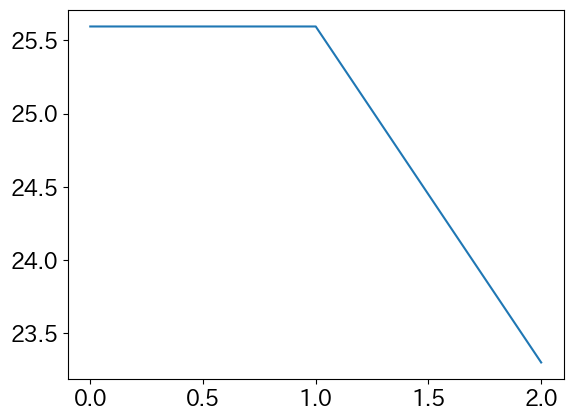

In [158]:
fig, ax = plt.subplots()
ax.plot(distance_history)
plt.show()